# Model 2: LA, BLA, CeL, CeM, LA_IN, and BLA_IN: add inhibitory interneurons that inhibit certain populations

1. Behavioral data
    - <span style="color:green">conditioned freezing
    - <span style="color:green">extinction-induced reduction of freezing
    - <span style="color:green">renewal of freezing when the CS is presented in the original context


2. Activity data
    - <span style="color:green">LA neurons (excitatory) become CS-responsive after conditioning
    - LA neurons (excitatory) maintain CS-responsiveness after extinction
    - <span style="color:green">BLA fear neurons (excitatory) become CS-responsive after conditioning and lose CS-responsiveness after extinction
    - <span style="color:green">BLA extinction neurons (excitatory) become CS-responsive after extinction
    - <span style="color:green">BLA persistent neurons (excitatory) become CS-responsive after conditioning and maintain their activity after extinction
    - <span style="color:green">CeL "on" neurons (inhibitory) become more responsive to CS following conditioning
    - <span style="color:green">CeL "off" neurons (inhibitory) become less responsive to CS following conditioning
    - LA "PV" neurons (inhibitory) become more responsive to CS (indirectly) during conditioning
    - LA "SOM" neurons (inhibitory) become less responsive to CS (indirectly) during conditioning
    - Inhibition of LA PNs by PV INs is reduced during conditioning
    - Presenting the US inhibits PV and SOM in LA, allowing LTP at CS-responsive LA PNs
    - INs in BLA are differentially recruited during extinction


3. Data produced by external perturbations (electrophysiology and pharmacology)
    - <span style="color:green">Inactivating LA during conditioning impairs fear learning
    - <span style="color:green">Inactivating LA during test impairs fear expression
    - Inactivating BLA during extinction impairs extinction learning
    - Activating BLA interneurons during conditioning impairs fear learning
    - Inactivating BLA interneurons during conditioning facilitates fear learning
    - Depolarizing LA neurons while presenting a CS induces weak fear learning
    - Destroying INs in BLA that target BLA fear neurons impairs extinction
    - Destroying INs in the ITC impairs BLA’s ability to inhibit CeA and impairs extinction
    - Upregulating DA and NE suppress feedforward inhibition and reduce fear conditioning 
    - <span style="color:green">Inactivation of CeL produces sponteneous freezing
    - Activation of CeL_on cells after conditioning causes freezing
    - <span style="color:green">Inactivation of CeL during conditioning reduces freezing at test
    - <span style="color:green">Inactivation of CeM after conditioning impairs freezing
    - <span style="color:green">Activation of CeM causes spontaneous freezing
    - 





In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.applied_input = 0
    def get_CS(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        self.CS = self.CSs[idx] if applied else np.zeros((self.dim_CS))
        return self.CS
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_applied_input(self, t):
        return self.applied_input

### Divide CeA into CeL and CeM, then model CS-US association in CeL and subsequent release of inhibition onto CeM

In [82]:
def build_network(
        seed = 0,
        nNeurons = 200,
        dim_CS = 3,
        dim_CTX = 10,
        nCTX = 2,
    ):

    net = nengo.Network(seed=seed)
    net.inputs = Inputs(nCS=1, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, seed=seed)
    net.config[nengo.Connection].synapse = 0.01
    net.config[nengo.Probe].synapse = 0.01
    intercepts_pos = nengo.dists.Uniform(0, 1)
    encoders_pos = nengo.dists.Choice([[1]])
    encoders_ctx = nengo.dists.Choice(net.inputs.CTXs)
    intercepts_ctx = (np.dot(net.inputs.CTXs, net.inputs.CTXs.T) - np.eye(nCTX)).flatten().max()

    with net:
        # inputs
        CS = nengo.Node(lambda t, x: net.inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: net.inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: net.inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        applied_input = nengo.Node(lambda t, x: net.inputs.get_applied_input(t), size_in=2)
        bias = nengo.Node(lambda t: 0.4)

        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX,
            intercepts=[intercepts_ctx]*dim_CTX*nNeurons, encoders=encoders_ctx)
        # amygdala ensembles
        LA = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        BLA = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        CeL = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, bias]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [freeze]
        # error populations
        error_LA = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        error_LA_noCS = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        error_CeL = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        error_CeL_noCS = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)

        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(CTX, external_CTX, synapse=None)
        nengo.Connection(bias, CeL[2], synapse=None)
        nengo.Connection(bias, CeM, synapse=None)
        # internal connections
        nengo.Connection(external_US, LA[1])  # transmit US to LA
        nengo.Connection(external_US, CeL[1])  # transmit US to CeL
        nengo.Connection(LA, BLA[:2])  # transmit [CS, US] from LA to BLA
        nengo.Connection(BLA[2], CeM, transform=0.6)  # CTX response (pos or neg) added to CeM state
        nengo.Connection(CeL, CeM, function=lambda x: x[0]-x[2], transform=1)  # CeL inhibits CeM (CS response - default)
        # learned connections
        external_to_la = nengo.Connection(external_CS, LA[0], function=lambda x: 0, learning_rule_type=nengo.PES(1e-4))
        external_to_bla = nengo.Connection(external_CTX, BLA[2], function=lambda x: 0, learning_rule_type=nengo.PES(1e-5))
        la_to_cel = nengo.Connection(LA[0], CeL[0], function=lambda x: 0, learning_rule_type=nengo.PES(8e-5))
        # error connections, LA
        nengo.Connection(LA, error_LA, function=lambda x: x[1]-x[0])  # US - (CS response)
        nengo.Connection(error_LA, external_to_la.learning_rule, transform=-1)
        nengo.Connection(LA, error_LA_noCS, function=lambda x: x[0])  # (CS response)
        nengo.Connection(external_CS, error_LA_noCS, function=lambda x: -np.sum(np.square(x)))  # any CS present
        nengo.Connection(error_LA_noCS, external_to_la.learning_rule, transform=2)
        # error connections, BLA
        nengo.Connection(BLA, error_BLA_safe, function=lambda x: x[0]+x[2]-x[1])  # CS response + CTX response (negative), removed if US present
        nengo.Connection(BLA, error_BLA_safe.neurons,
            function=lambda x: 1-x[0], transform=-1e0*np.ones((nNeurons,1)))  # inhibit unless CS is present
        nengo.Connection(BLA, error_BLA_safe.neurons,
            function=lambda x: x[1], transform=-1e0*np.ones((nNeurons,1)))  # inhibit if US is present
        nengo.Connection(error_BLA_safe, external_to_bla.learning_rule, transform=0.3)
        nengo.Connection(BLA, error_BLA_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
        nengo.Connection(BLA, error_BLA_fear.neurons,
            function=lambda x: 1-x[1], transform=-1e0*np.ones((nNeurons,1)))  # inhibit unless US is present
        nengo.Connection(error_BLA_fear, external_to_bla.learning_rule, transform=-1)
        # error connections, CeL
        nengo.Connection(CeL, error_CeL, function=lambda x: x[1]-x[0])  # US - CS response
        nengo.Connection(error_CeL, la_to_cel.learning_rule, transform=-1)
        nengo.Connection(CeL, error_CeL_noCS, function=lambda x: x[0])  # CS response
        nengo.Connection(external_CS, error_CeL_noCS, function=lambda x: -np.sum(np.square(x)))  # any CS present

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pAppliedInput = nengo.Probe(applied_input, synapse=None)
        net.pLA_spikes = nengo.Probe(LA.neurons)
        net.pBLA_spikes = nengo.Probe(BLA.neurons)
        net.pCeL_spikes = nengo.Probe(CeL.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pLA = nengo.Probe(LA)
        net.pBLA = nengo.Probe(BLA)
        net.pCeL = nengo.Probe(CeL)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_LA_noCS = nengo.Probe(error_LA_noCS)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pError_CeL_noCS = nengo.Probe(error_CeL_noCS)
        
        # for later reference
        net.LA = LA
        net.BLA = BLA
        net.CeL = CeL
        net.CeM = CeM
        net.applied_input = applied_input
        net.error_CeL = error_CeL
        net.error_CeL_noCS = error_CeL_noCS
        net.error_LA = error_LA
        net.error_LA_noCS = error_LA_noCS
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        net.external_to_la = nengo.Probe(external_to_la, 'weights')
        net.external_to_bla = nengo.Probe(external_to_bla, 'weights')
        net.la_to_cel = nengo.Probe(la_to_cel, 'weights')

    return net

## Confirm that Model 2 reproduces results from Model 1, and captures basic behavioral and spiking data

In [4]:
dt = 0.001
nCond = 5
nExt = 10

net = build_network()
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T_baseline_inactive = int(1/dt)
    T_baseline_active = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("test (CTX_A)")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T_expression_cond_inactive = int((2+2*nCond+1)/dt)
    T_expression_cond_active = int((2+2*nCond+2)/dt)
    print("extinction")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    print("test (CTX_B)")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    sim.run(2)
    T_expression_ext_inactive = int((2+2*nCond+2+2*nExt+1)/dt)
    T_expression_ext_active = int((2+2*nCond+2+2*nExt+2)/dt)
    print("test (CTX_A)")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T_expression_renewal_inactive = int((2+2*nCond+2+2*nExt+2+1)/dt)
    T_expression_renewal_active = int((2+2*nCond+2+2*nExt+2+2)/dt)

baseline
conditioning
test (CS+CTX_A)
extinction
test (CS+CTX_B)
test (CS+CTX_A)


### Behavior

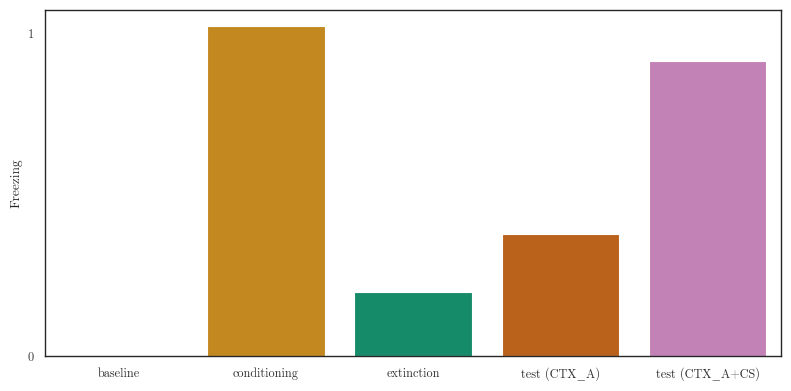

In [5]:
data = pd.DataFrame(columns=["Freezing", "Experiment"])
data = data.append({
    "Freezing": np.mean(sim.data[net.pCeM][T_baseline_inactive: T_baseline_active]),
    "Experiment": "baseline"},
    ignore_index=True)
data = data.append({
    "Freezing": np.mean(sim.data[net.pCeM][T_expression_cond_inactive: T_expression_cond_active]),
    "Experiment": 'conditioning'},
    ignore_index=True)
data = data.append({
    "Freezing": np.mean(sim.data[net.pCeM][T_expression_ext_inactive: T_expression_ext_active]),
    "Experiment": 'extinction'},
    ignore_index=True)
data = data.append({
    "Freezing": np.mean(sim.data[net.pCeM][T_expression_ext_active: T_expression_renewal_inactive]),
    "Experiment": 'test (CTX_A)'},
    ignore_index=True)
data = data.append({
    "Freezing": np.mean(sim.data[net.pCeM][T_expression_renewal_inactive: T_expression_renewal_active]),
    "Experiment": 'test (CTX_A+CS)'},
    ignore_index=True)

fig, ax = plt.subplots(figsize=((8,4)))
sns.barplot(data=data, x='Experiment', y="Freezing", palette=palette)
ax.set(xlabel=None, yticks=((0,1)))
plt.tight_layout()

### LA and CeL have "on" and "off" neurons

34.5% of LA neurons are 'on' neurons
22.0% of LA neurons are 'off' neurons
22.8% of CeL neurons are 'on' neurons
13.0% of CeL neurons are 'off' neurons


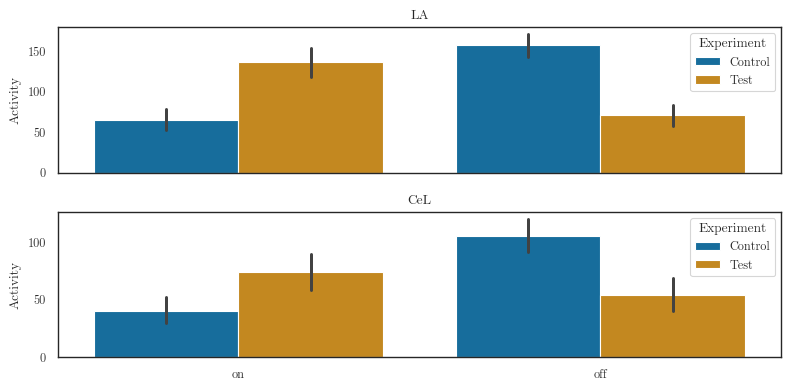

In [6]:
LA_baseline = sim.data[net.pLA_spikes][T_baseline_inactive: T_baseline_active]
LA_expression = sim.data[net.pLA_spikes][T_expression_cond_inactive: T_expression_cond_active]
CeL_baseline = sim.data[net.pCeL_spikes][T_baseline_inactive: T_baseline_active]
CeL_expression = sim.data[net.pCeL_spikes][T_expression_cond_inactive: T_expression_cond_active]

dLA = np.mean(LA_expression - LA_baseline, axis=0)
dCeL = np.mean(LA_expression - LA_baseline, axis=0)
A_thr_on = 1.2  # neurons are "increasing" if they fire >20% more than the post-conditioning baseline
A_thr_off = 0.8  # neurons are "decreasing" if they fire at <80% of post-conditioning baseline

LA_on = np.where(np.mean(LA_expression, axis=0) > A_thr_on*np.mean(LA_baseline, axis=0))[0]
LA_off = np.where(np.mean(LA_expression, axis=0) < A_thr_off*np.mean(LA_baseline, axis=0))[0]
LA_other = np.setdiff1d(np.arange(dLA.shape[0]), np.concatenate((LA_on, LA_off)))
CeL_on = np.where(np.mean(CeL_expression, axis=0) > A_thr_on*np.mean(CeL_baseline, axis=0))[0]
CeL_off = np.where(np.mean(CeL_expression, axis=0) < A_thr_off*np.mean(CeL_baseline, axis=0))[0]
CeL_other = np.setdiff1d(np.arange(dCeL.shape[0]), np.concatenate((CeL_on, CeL_off)))

print(f"{len(LA_on)/len(dLA)*100:.3}% of LA neurons are 'on' neurons")
print(f"{len(LA_off)/len(dLA)*100:.3}% of LA neurons are 'off' neurons")
print(f"{len(CeL_on)/len(dCeL)*100:.3}% of CeL neurons are 'on' neurons")
print(f"{len(CeL_off)/len(dCeL)*100:.3}% of CeL neurons are 'off' neurons")

data = pd.DataFrame(columns=["neuron", "region", "CS response", "Activity", "Experiment"])
for n in LA_on:
    data = data.append({"neuron": n, "region": "LA", "CS response": "on", "Activity": np.mean(LA_baseline[:,n]), "Experiment": "Control"}, ignore_index=True)
    data = data.append({"neuron": n, "region": "LA", "CS response": "on", "Activity": np.mean(LA_expression[:,n]), "Experiment": "Test"}, ignore_index=True)
for n in LA_off:
    data = data.append({"neuron": n, "region": "LA", "CS response": "off", "Activity": np.mean(LA_baseline[:,n]), "Experiment": "Control"}, ignore_index=True)
    data = data.append({"neuron": n, "region": "LA", "CS response": "off", "Activity": np.mean(LA_expression[:,n]), "Experiment": "Test"}, ignore_index=True)
for n in CeL_on:
    data = data.append({"neuron": n, "region": "CeL", "CS response": "on", "Activity": np.mean(CeL_baseline[:,n]), "Experiment": "Control"}, ignore_index=True)
    data = data.append({"neuron": n, "region": "CeL", "CS response": "on", "Activity": np.mean(CeL_expression[:,n]), "Experiment": "Test"}, ignore_index=True)
for n in CeL_off:
    data = data.append({"neuron": n, "region": "CeL", "CS response": "off", "Activity": np.mean(CeL_baseline[:,n]), "Experiment": "Control"}, ignore_index=True)
    data = data.append({"neuron": n, "region": "CeL", "CS response": "off", "Activity": np.mean(CeL_expression[:,n]), "Experiment": "Test"}, ignore_index=True)
    
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=((8,4)), sharex=True)
sns.barplot(data=data.query("region=='LA'"), x="CS response", y="Activity", hue="Experiment", palette=palette, ax=axes[0])
sns.barplot(data=data.query("region=='CeL'"), x="CS response", y="Activity", hue="Experiment", palette=palette, ax=axes[1])
axes[0].set(xlabel=None, title="LA")
axes[1].set(xlabel=None, title="CeL")
plt.tight_layout()

### BLA has "fear", "expression", and "persistent" neurons

20.3% of BLA neurons are 'fear neurons'
21.0% of BLA neurons are 'extinction neurons'
58.7% of BLA neurons are 'persistent neurons'


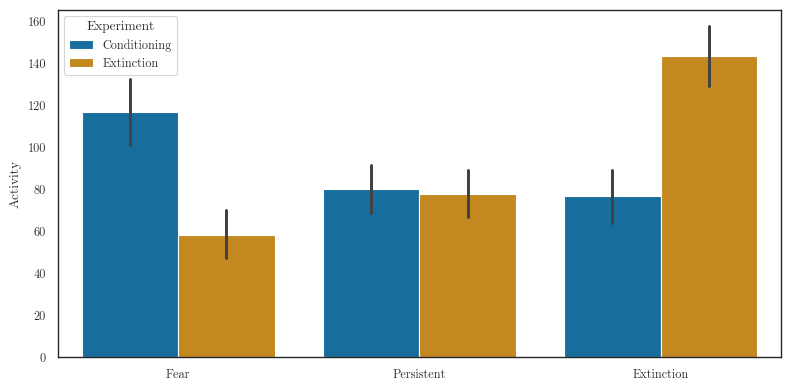

In [7]:
A_post_cond = sim.data[net.pBLA_spikes][T_expression_cond_inactive: T_expression_cond_active]
A_post_ext = sim.data[net.pBLA_spikes][T_expression_ext_inactive: T_expression_ext_active]
dA_ext = np.mean(A_post_ext - A_post_cond, axis=0)
A_thr_pos = 1.2  # neurons are "increasing" if they fire >20% more than the post-conditioning baseline
A_thr_neg = 0.8  # neurons are "decreasing" if they fire at <80% of post-conditioning baseline
extinction_neurons = np.where(np.mean(A_post_ext, axis=0) > A_thr_pos*np.mean(A_post_cond, axis=0))[0]
fear_neurons = np.where(np.mean(A_post_ext, axis=0) < A_thr_neg*np.mean(A_post_cond, axis=0))[0]
all_neurons = np.arange(dA_ext.shape[0])
nonpersistent_neurons = np.concatenate((extinction_neurons, fear_neurons))
persistent_neurons = np.setdiff1d(all_neurons, nonpersistent_neurons)
print(f"{len(fear_neurons)/len(dA_ext)*100:.3}% of BLA neurons are 'fear neurons'")
print(f"{len(extinction_neurons)/len(dA_ext)*100:.3}% of BLA neurons are 'extinction neurons'")
print(f"{len(persistent_neurons)/len(dA_ext)*100:.3}% of BLA neurons are 'persistent neurons'")

data = pd.DataFrame(columns=["neuron", "type", "Activity", "Experiment"])
for n in fear_neurons:
    data = data.append({"neuron": n, "type": "Fear", "Activity": np.mean(A_post_cond[:,n]), "Experiment": "Conditioning"}, ignore_index=True)
    data = data.append({"neuron": n, "type": "Fear", "Activity": np.mean(A_post_ext[:,n]), "Experiment": "Extinction"}, ignore_index=True)
for n in persistent_neurons:
    data = data.append({"neuron": n, "type": "Persistent", "Activity": np.mean(A_post_cond[:,n]), "Experiment": "Conditioning"}, ignore_index=True)
    data = data.append({"neuron": n, "type": "Persistent", "Activity": np.mean(A_post_ext[:,n]), "Experiment": "Extinction"}, ignore_index=True)
for n in extinction_neurons:
    data = data.append({"neuron": n, "type": "Extinction", "Activity": np.mean(A_post_cond[:,n]), "Experiment": "Conditioning"}, ignore_index=True)
    data = data.append({"neuron": n, "type": "Extinction", "Activity": np.mean(A_post_ext[:,n]), "Experiment": "Extinction"}, ignore_index=True)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
sns.barplot(data=data, x='type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(xlabel=None)
plt.tight_layout()

### LA "on" neurons maintain response properties after extinction

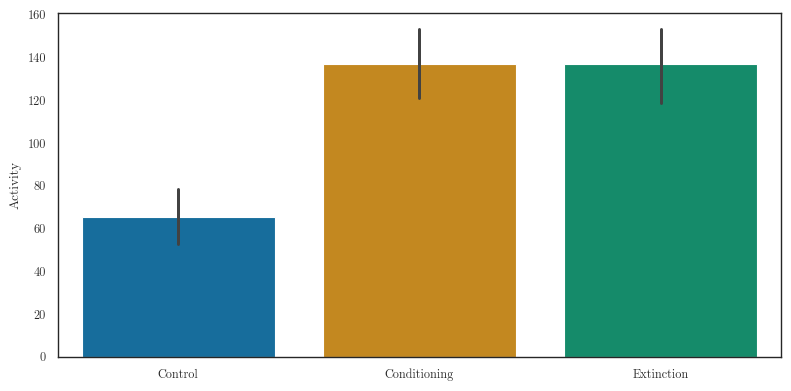

In [8]:
LA_baseline = sim.data[net.pLA_spikes][T_baseline_inactive: T_baseline_active]
LA_conditioning = sim.data[net.pLA_spikes][T_expression_cond_inactive: T_expression_cond_active]
LA_extinction = sim.data[net.pLA_spikes][T_expression_ext_inactive: T_expression_ext_active]

dLA = np.mean(LA_conditioning - LA_baseline, axis=0)
A_thr_on = 1.2  # neurons are "increasing" if they fire >20% more than the post-conditioning baseline
LA_on = np.where(np.mean(LA_expression, axis=0) > A_thr_on*np.mean(LA_baseline, axis=0))[0]

data = pd.DataFrame(columns=["neuron", "Experiment", "Activity"])
for n in LA_on:
    data = data.append({"neuron": n, "Activity": np.mean(LA_baseline[:,n]), "Experiment": "Control"}, ignore_index=True)
    data = data.append({"neuron": n, "Activity": np.mean(LA_expression[:,n]), "Experiment": "Conditioning"}, ignore_index=True)
    data = data.append({"neuron": n, "Activity": np.mean(LA_expression[:,n]), "Experiment": "Extinction"}, ignore_index=True)

fig, ax = plt.subplots(figsize=((8,4)))
sns.barplot(data=data, x="Experiment", y="Activity", palette=palette, ax=ax)
ax.set(xlabel=None)
plt.tight_layout()

## CeL and CeM Experiments

### Activation of CeM causes spontaneous freezing

baseline
CeM activation


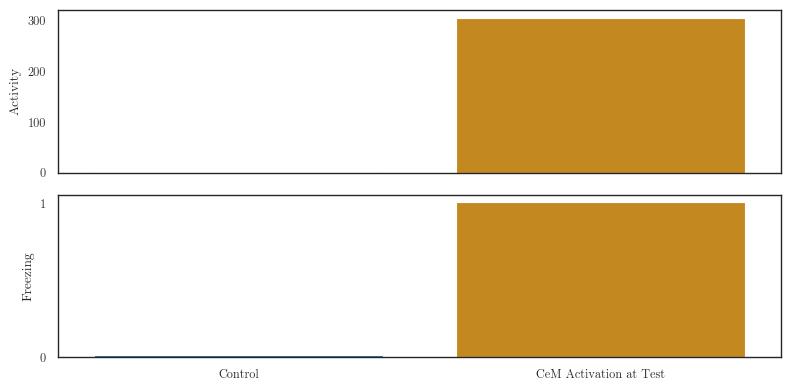

In [9]:
net = build_network()
with net:
    nengo.Connection(net.applied_input, net.CeM)

dt = 0.001
nCond = 5
nExt = 10

sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T0 = int(2/dt)
    print("CeM activation")
    net.inputs.applied_input = 1
    sim.run(2)
    T1 = int((2+2)/dt)

data_sim = pd.DataFrame(columns=["Freezing", "Activity", "Experiment"])
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][0: T0]),
    "Activity": np.mean(sim.data[net.pCeM_spikes][0: T0]),
    "Experiment": "Control"},
    ignore_index=True)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T0: T1]),
    "Activity": np.mean(sim.data[net.pCeM_spikes][T0: T1]),
    "Experiment": 'CeM Activation at Test'},
    ignore_index=True)

fig, axes = plt.subplots(figsize=((8,4)), sharex=True, nrows=2, ncols=1)
sns.barplot(data=data_sim, x='Experiment', y="Activity", palette=palette[:2], ax=axes[0])
sns.barplot(data=data_sim, x='Experiment', y="Freezing", palette=palette[:2], ax=axes[1])
axes[0].set(xlabel=None)
axes[1].set(xlabel=None, yticks=((0,1)))
plt.tight_layout()

### Inactivation of CeL produces spontaneous freezing

baseline
CeL Inactivation


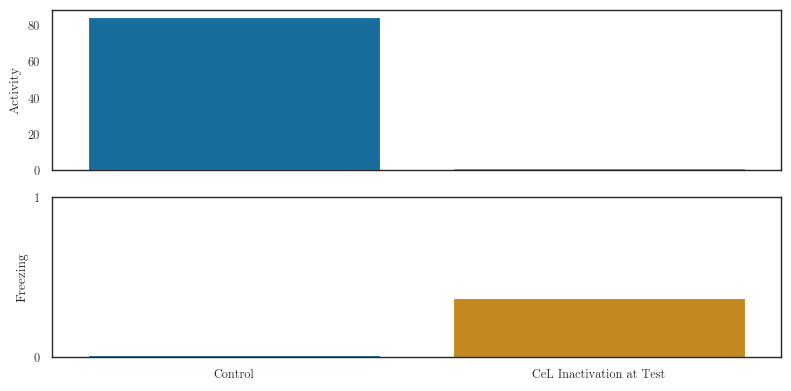

In [10]:
net = build_network()
with net:
    nengo.Connection(net.applied_input, net.CeL.neurons, transform=-1e0*np.ones((net.CeL.n_neurons,1)))

dt = 0.001
nCond = 5
nExt = 10

sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T0 = int(2/dt)
    print("CeL Inactivation")
    net.inputs.applied_input = 1
    sim.run(2)
    T1 = int((2+2)/dt)

data_sim = pd.DataFrame(columns=["Freezing", "Activity", "Experiment"])
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][0: T0]),
    "Activity": np.mean(sim.data[net.pCeL_spikes][0: T0]),
    "Experiment": "Control"},
    ignore_index=True)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T0: T1]),
    "Activity": np.mean(sim.data[net.pCeL_spikes][T0: T1]),
    "Experiment": 'CeL Inactivation at Test'},
    ignore_index=True)

fig, axes = plt.subplots(figsize=((8,4)), sharex=True, nrows=2, ncols=1)
sns.barplot(data=data_sim, x='Experiment', y="Activity", palette=palette[:2], ax=axes[0])
sns.barplot(data=data_sim, x='Experiment', y="Freezing", palette=palette[:2], ax=axes[1])
axes[0].set(xlabel=None)
axes[1].set(xlabel=None, yticks=((0,1)))
plt.tight_layout()

### Inactivation of CeM after conditioning impairs freezing

baseline
conditioning
test
test with CeM inactivation


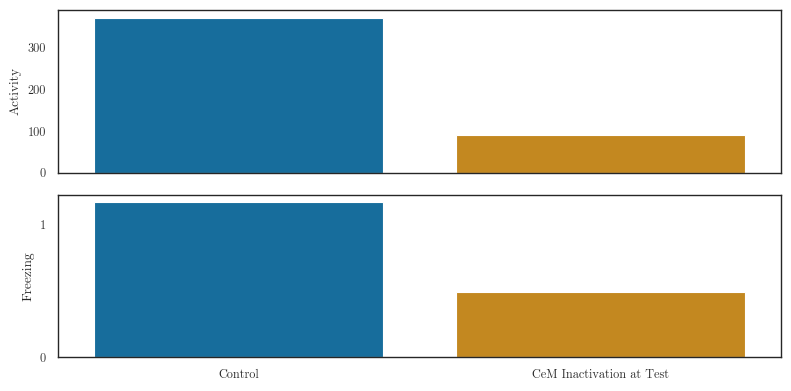

In [11]:
net = build_network()
with net:
    nengo.Connection(net.applied_input, net.CeM)

dt = 0.001
nCond = 5
nExt = 10

sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T0 = int(1/dt)
    T1 = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("test")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US
    sim.run(2)
    T2 = int((2+2*nCond+1)/dt)
    T3 = int((2+2*nCond+2)/dt)
    print("test with CeM inactivation")
    net.inputs.applied_input = -1
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US
    sim.run(2)
    T4 = int((2+2*nCond+2+1)/dt)
    T5 = int((2+2*nCond+2+2)/dt)

data_sim = pd.DataFrame(columns=["Freezing", "Activity", "Experiment"])
# data_sim = data_sim.append({
#     "Freezing": np.mean(sim.data[net.pCeM][T0: T1]),
#     "Activity": np.mean(sim.data[net.pCeM_spikes][T0: T1]),
#     "Experiment": "baseline"},
#     ignore_index=True)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T2: T3]),
    "Activity": np.mean(sim.data[net.pCeM_spikes][T2: T3]),
    "Experiment": 'Control'},
    ignore_index=True)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T4: T5]),
    "Activity": np.mean(sim.data[net.pCeM_spikes][T4: T5]),
    "Experiment": 'CeM Inactivation at Test'},
    ignore_index=True)

fig, axes = plt.subplots(figsize=((8,4)), sharex=True, nrows=2, ncols=1)
sns.barplot(data=data_sim, x='Experiment', y="Activity", palette=palette, ax=axes[0])
sns.barplot(data=data_sim, x='Experiment', y="Freezing", palette=palette, ax=axes[1])
axes[0].set(xlabel=None)
axes[1].set(xlabel=None, yticks=((0,1)))
plt.tight_layout()

### Inactivation of CeL during conditioning impairs freezing

In [90]:
data_sim = pd.DataFrame(columns=["Freezing", "Activity", "Experiment"])

dt = 0.001
nCond = 5
nExt = 10

net = build_network()
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.applied_input = 0
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T0 = int(1/dt)
    T1 = int(2/dt)
    print("conditioning")
    net.inputs.applied_input = 0
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2 = int((2+2*nCond)/dt)
    print("test")
    net.inputs.applied_input = 0
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T3 = int((2+2*nCond+1)/dt)
    T4 = int((2+2*nCond+2)/dt)
# data_sim = data_sim.append({
#     "Freezing": np.mean(sim.data[net.pCeM][T0: T1]),
#     "Activity": np.mean(sim.data[net.pCeL_spikes][T0: T1]),
#     "Experiment": "baseline"},
#     ignore_index=True)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T3: T4]),
    "Activity": np.mean(sim.data[net.pCeL_spikes][T1: T2]),
    "Experiment": 'Control'},
    ignore_index=True)
la_to_cel_weights_control = sim.data[net.la_to_cel][-1].ravel()


net = build_network()
with net:
    nengo.Connection(net.applied_input, net.CeL.neurons, transform=-1e0*np.ones((net.CeL.n_neurons,1)))
    nengo.Connection(net.applied_input, net.error_CeL.neurons, transform=-1e0*np.ones((net.error_CeL.n_neurons,1)))
    nengo.Connection(net.applied_input, net.error_CeL_noCS.neurons, transform=-1e0*np.ones((net.error_CeL_noCS.n_neurons,1)))
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.applied_input = 0
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T0 = int(1/dt)
    T1 = int(2/dt)
    print("conditioning with CeL inactivation")
    net.inputs.applied_input = 1
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2 = int((2+2*nCond)/dt)
    print("test")
    net.inputs.applied_input = 0
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T3 = int((2+2*nCond+1)/dt)
    T4 = int((2+2*nCond+2)/dt)
# data_sim = data_sim.append({
#     "Freezing": np.mean(sim.data[net.pCeM][T0: T1]),
#     "Activity": np.mean(sim.data[net.pCeL_spikes][T0: T1]),
#     "Experiment": "baseline"},
#     ignore_index=True)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T3: T4]),
    "Activity": np.mean(sim.data[net.pCeL_spikes][T1: T2]),
    "Experiment": 'CeL Inactivation at Conditioning'},
    ignore_index=True)
la_to_cel_weights_experiment = sim.data[net.la_to_cel][-1].ravel()


# fig, axes = plt.subplots(figsize=((8,4)), sharex=True, nrows=2, ncols=1)
# sns.barplot(data=data_sim, x='Experiment', y="Activity", palette=palette, ax=axes[0])
# sns.barplot(data=data_sim, x='Experiment', y="Freezing", palette=palette, ax=axes[1])
# axes[0].set(xlabel=None)
# axes[1].set(xlabel=None, yticks=((0,1)))
# plt.tight_layout()

baseline
conditioning
test
baseline
conditioning with CeL inactivation
test


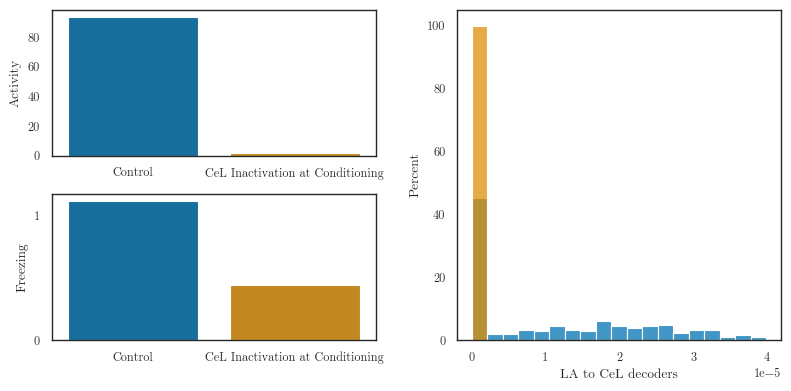

In [91]:
bins = np.linspace(np.min(la_to_cel_weights_control), np.max(la_to_cel_weights_control), 20)
fig, axes = plt.subplot_mosaic('''ac;bc''', figsize=((8,4)))
sns.barplot(data=data_sim, x='Experiment', y="Activity", palette=palette, ax=axes['a'])
sns.barplot(data=data_sim, x='Experiment', y="Freezing", palette=palette, ax=axes['b'])
sns.histplot(la_to_cel_weights_control, bins=bins, stat='percent', color=palette[0], label="Control", ax=axes['c'])
sns.histplot(la_to_cel_weights_experiment, bins=bins, stat='percent', color=palette[1], label="CeL Inactivation at Conditioning", ax=axes['c'])
axes['a'].set(xlabel=None)
axes['b'].set(xlabel=None, yticks=((0,1)))
axes['c'].set(xlabel="LA to CeL decoders")
plt.tight_layout()

## LA Experiments

### Inactivation of LA during conditioning impairs fear learning

baseline
conditioning
test
baseline
conditioning with LA inactivation
test


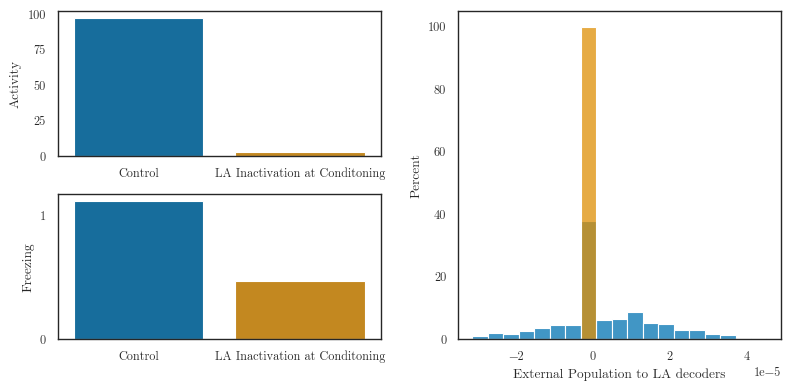

In [92]:
data_sim = pd.DataFrame(columns=["Freezing", "Activity", "Experiment"])

dt = 0.001
nCond = 5
nExt = 10

net = build_network()
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T0 = int(1/dt)
    T1 = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2 = int((2+2*nCond)/dt)
    print("test")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T3 = int((2+2*nCond+1)/dt)
    T4 = int((2+2*nCond+2)/dt)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T3: T4]),
    "Activity": np.mean(sim.data[net.pLA_spikes][T1: T2]),
    "Experiment": 'Control'},
    ignore_index=True)
external_to_la_weights_control = sim.data[net.external_to_la][-1].ravel()


net = build_network()
with net:
    nengo.Connection(net.applied_input, net.LA.neurons, transform=-1e0*np.ones((net.LA.n_neurons,1)))
    nengo.Connection(net.applied_input, net.error_LA.neurons, transform=-1e0*np.ones((net.error_LA.n_neurons,1)))
    nengo.Connection(net.applied_input, net.error_LA_noCS.neurons, transform=-1e0*np.ones((net.error_LA_noCS.n_neurons,1)))
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T0 = int(1/dt)
    T1 = int(2/dt)
    print("conditioning with LA inactivation")
    net.inputs.applied_input = 1
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2 = int((2+2*nCond)/dt)
    print("test")
    net.inputs.applied_input = 0
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T3 = int((2+2*nCond+1)/dt)
    T4 = int((2+2*nCond+2)/dt)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T3: T4]),
    "Activity": np.mean(sim.data[net.pLA_spikes][T1: T2]),
    "Experiment": 'LA Inactivation at Conditoning'},
    ignore_index=True)
external_to_la_weights_experiment = sim.data[net.external_to_la][-1].ravel()

bins = np.linspace(np.min(external_to_la_weights_control), np.max(external_to_la_weights_control), 20)
fig, axes = plt.subplot_mosaic('''ac;bc''', figsize=((8,4)))
sns.barplot(data=data_sim, x='Experiment', y="Activity", palette=palette, ax=axes['a'])
sns.barplot(data=data_sim, x='Experiment', y="Freezing", palette=palette, ax=axes['b'])
sns.histplot(external_to_la_weights_control, bins=bins, stat='percent', color=palette[0], label="Control", ax=axes['c'])
sns.histplot(external_to_la_weights_experiment, bins=bins, stat='percent', color=palette[1], label="CeL Inactivation at Conditioning", ax=axes['c'])
axes['a'].set(xlabel=None)
axes['b'].set(xlabel=None, yticks=((0,1)))
axes['c'].set(xlabel="External Population to LA decoders")
plt.tight_layout()

### Inactivation of LA after conditioning impairs fear expression

baseline
conditioning
test
baseline
conditioning with LA inactivation
test


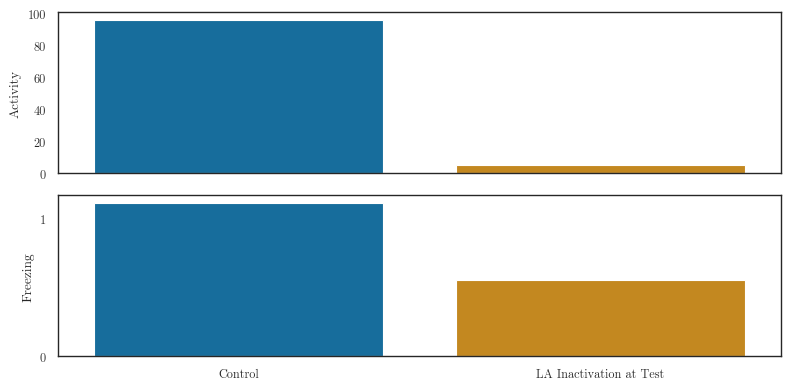

In [78]:
data_sim = pd.DataFrame(columns=["Freezing", "Activity", "Experiment"])

dt = 0.001
nCond = 5
nExt = 10

net = build_network()
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T0 = int(1/dt)
    T1 = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2 = int((2+2*nCond)/dt)
    print("test")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T3 = int((2+2*nCond+1)/dt)
    T4 = int((2+2*nCond+2)/dt)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T3: T4]),
    "Activity": np.mean(sim.data[net.pLA_spikes][T3: T4]),
    "Experiment": 'Control'},
    ignore_index=True)


net = build_network()
with net:
    nengo.Connection(net.applied_input, net.LA.neurons, transform=-1e0*np.ones((net.LA.n_neurons,1)))
    nengo.Connection(net.applied_input, net.error_LA.neurons, transform=-1e0*np.ones((net.error_LA.n_neurons,1)))
    nengo.Connection(net.applied_input, net.error_LA_noCS.neurons, transform=-1e0*np.ones((net.error_LA_noCS.n_neurons,1)))
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T0 = int(1/dt)
    T1 = int(2/dt)
    print("conditioning with LA inactivation")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2 = int((2+2*nCond)/dt)
    print("test")
    net.inputs.applied_input = 1
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T3 = int((2+2*nCond+1)/dt)
    T4 = int((2+2*nCond+2)/dt)
data_sim = data_sim.append({
    "Freezing": np.mean(sim.data[net.pCeM][T3: T4]),
    "Activity": np.mean(sim.data[net.pLA_spikes][T3: T4]),
    "Experiment": 'LA Inactivation at Test'},
    ignore_index=True)

fig, axes = plt.subplots(figsize=((8,4)), sharex=True, nrows=2, ncols=1)
sns.barplot(data=data_sim, x='Experiment', y="Activity", palette=palette, ax=axes[0])
sns.barplot(data=data_sim, x='Experiment', y="Freezing", palette=palette, ax=axes[1])
axes[0].set(xlabel=None)
axes[1].set(xlabel=None, yticks=((0,1)))
plt.tight_layout()

## BLA Experiments

### Inactivating BLA during extinction impairs extinction learning

In [93]:
dt = 0.001
nCond = 5
nExt = 10
data_sim = pd.DataFrame(columns=["Freezing", "Activity", "Experiment"])

net = build_network()
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T_baseline_inactive = int(1/dt)
    T_baseline_active = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("test (CTX_A)")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T_expression_cond_inactive = int((2+2*nCond+1)/dt)
    T_expression_cond_active = int((2+2*nCond+2)/dt)
    print("extinction")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    T_extinction_start = int((2+2*nCond+2)/dt)
    T_extinction_end = int((2+2*nCond+2+2*nExt)/dt)
    print("test (CTX_B)")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    sim.run(2)
    T_expression_ext_inactive = int((2+2*nCond+2+2*nExt+1)/dt)
    T_expression_ext_active = int((2+2*nCond+2+2*nExt+2)/dt)
    
data_sim = data_sim.append({
    "Activity": np.mean(sim.data[net.pBLA_spikes][T_extinction_start: T_extinction_end]),
    "Freezing": np.mean(sim.data[net.pCeM][T_expression_ext_inactive: T_expression_ext_active]),
    "Experiment": 'Control'},
    ignore_index=True)
external_to_bla_weights_control = sim.data[net.external_to_bla][T_extinction_end].ravel()


net = build_network()
with net:
    nengo.Connection(net.applied_input, net.BLA.neurons, transform=-1e0*np.ones((net.BLA.n_neurons,1)))
    nengo.Connection(net.applied_input, net.error_BLA_safe.neurons, transform=-1e0*np.ones((net.error_BLA_safe.n_neurons,1)))
    nengo.Connection(net.applied_input, net.error_BLA_fear.neurons, transform=-1e0*np.ones((net.error_BLA_fear.n_neurons,1)))
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T_baseline_inactive = int(1/dt)
    T_baseline_active = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("test (CTX_A)")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T_expression_cond_inactive = int((2+2*nCond+1)/dt)
    T_expression_cond_active = int((2+2*nCond+2)/dt)
    print("extinction")
    net.inputs.applied_input = 1
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    print("test (CTX_B)")
    net.inputs.applied_input = 0
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    sim.run(2)
    T_expression_ext_inactive = int((2+2*nCond+2+2*nExt+1)/dt)
    T_expression_ext_active = int((2+2*nCond+2+2*nExt+2)/dt)
    
data_sim = data_sim.append({
    "Activity": np.mean(sim.data[net.pBLA_spikes][T_extinction_start: T_extinction_end]),
    "Freezing": np.mean(sim.data[net.pCeM][T_expression_ext_inactive: T_expression_ext_active]),
    "Experiment": 'BLA Inactivation at Extinction'},
    ignore_index=True)
external_to_bla_weights_experiment = sim.data[net.external_to_bla][T_extinction_end].ravel()

baseline
conditioning
test (CTX_A)
extinction
test (CTX_B)
baseline
conditioning
test (CTX_A)
extinction
test (CTX_B)


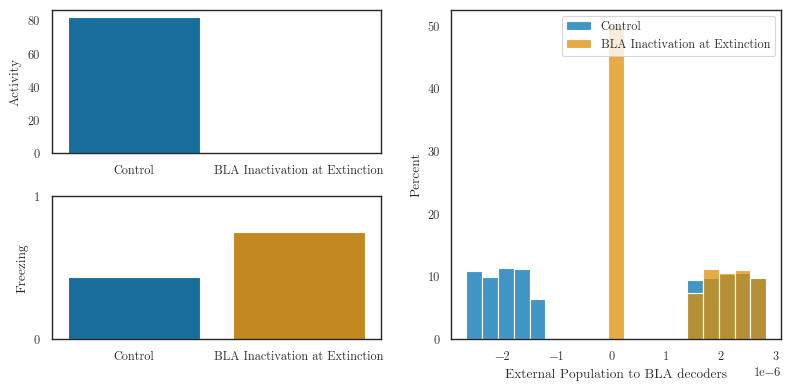

In [94]:
bins = np.linspace(np.min(external_to_bla_weights_control), np.max(external_to_bla_weights_control), 20)
fig, axes = plt.subplot_mosaic('''ac;bc''', figsize=((8,4)))
sns.barplot(data=data_sim, x='Experiment', y="Activity", palette=palette, ax=axes['a'])
sns.barplot(data=data_sim, x='Experiment', y="Freezing", palette=palette, ax=axes['b'])
sns.histplot(external_to_bla_weights_control, bins=bins, stat='percent', color=palette[0], label="Control", ax=axes['c'])
sns.histplot(external_to_bla_weights_experiment, bins=bins, stat='percent', color=palette[1], label="BLA Inactivation at Extinction", ax=axes['c'])
axes['a'].set(xlabel=None)
axes['b'].set(xlabel=None, yticks=((0,1)))
axes['c'].set(xlabel="External Population to BLA decoders")
axes['c'].legend()
plt.tight_layout()